In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from statsmodels import robust
import glob
import os
import argparse
import sys
from tqdm import tqdm
import librosa



# constant
SIG_PAD = -10
WIN_SIZE = 256




''' short time Fourier transform for 1 d signal '''
def STFT(input_signal, chunk_size, spacing = 1):
    # assert 1D array
    assert len(input_signal.shape) == 1
    num_chunks  = len(input_signal) // chunk_size
    # reshape into different chunks
    arr = input_signal[:num_chunks * chunk_size].reshape( ( -1, chunk_size ) )
    # real Fourier transform of the chunks
    res = np.fft.rfft( arr, chunk_size )
    # times
    times = np.arange( num_chunks ) * ( chunk_size * spacing )
    # frequencies
    frequencies = np.fft.rfftfreq( chunk_size, spacing )
    return res, times, frequencies




''' Inverse operation of stft'''
def invSTFT(stftArr, chunk_size):
    arr = np.fft.irfft( stftArr )[:, :chunk_size]
    return np.reshape( arr, -1 )




''' Display signal, can add a title. If cond_squeeze is True, 
    it means that first dim is batch (usually 1)'''
def disp(spectrogram, title = None):
    spectrogram = librosa.amplitude_to_db(spectrogram)
    if len(spectrogram.shape) == 3 and spectrogram.shape[0] == 1:
        plt.pcolormesh(spectrogram[0], shading='gouraud')
    elif len(spectrogram.shape) == 2:
        plt.pcolormesh(spectrogram, shading='gouraud')
    else:
        print("Wrong shape " + spectrogram.shape + ". Expected (1, N, M) or (N, M)" )
        
    plt.ylabel('Frequency in Hz')
    plt.xlabel('Time in s')
    if title is not None:
        plt.title(title)
    plt.show()


def disp_sig(y, title = None):
    plt.plot(y)
    if title is not None:
        plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()




"""Apply frequency masking to the spectrogram. Convetions from the SpecAugment paper"""
def spec_freq_mask(spec, num_masks):
    freq_mask_spec = spec.T.copy()
    num_freq = freq_mask_spec.shape[0]
    # not to select the first frequency, too important
    F = num_freq - 1

    for i in range(num_masks):        
        f = random.randrange(0, F)
        # 1 isntead of 0 not to select the first frequency, too important
        f_zero = random.randrange(1, num_freq - f)
        # If no frequency to mask, do nothing

        if(f==0): 
            continue
        
        # bound the freq mask 
        if(f > 3):
            f = 3
        freq_mask_spec[f_zero:f_zero + f] = 0

    return freq_mask_spec.T




"""Apply time masking to the spectrogram. Convetions from the SpecAugment paper"""
def spec_time_mask(spec, num_masks):
    time_mask_spec = spec.T.copy()
    num_times = time_mask_spec.shape[1]
    T = num_times
    
    for i in range(num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, num_times - t)
        # If no frequency to mask, do nothing
        
        if(t == 0):
            continue
        
        # bound the time mask
        if(t > 5):
            t = 5 
        time_mask_spec[:,t_zero:t_zero + t] = 0

    return time_mask_spec.T






'''Data augmentation for a particular signal using frequency mask'''
def apply_frequency_mask(input_sig, chunk_size = 10, num_masks=1):
    #compute the spectrogram and phase of the stft
    s, t, f  = STFT(input_sig, chunk_size)
    spec = np.abs(s)**2
    disp(spec.T)
    angles = np.angle(s)
    # mask frequencies
    freq_mask_spec = spec_freq_mask(spec, num_masks)
    # invert stft
    disp(freq_mask_spec.T)

    y = invSTFT(np.sqrt(freq_mask_spec)*np.exp(1j*angles), chunk_size)
    # make the signal on the same scale as the input signal
    y = -y#(y - np.median(y)) / np.float32(robust.mad(y))
    
    sig_min = np.min(input_sig)
    sig_max = np.max(input_sig)
    y = (y-np.min(y)) / (np.max(y) - np.min(y))
    y = (sig_max - sig_min)*y + sig_min

    disp_sig(y.T, "Frequency mask")
    disp_sig(input_sig.T, "Original")
    
    return y





'''Data augmentation for a particular signal using time mask'''
def apply_time_mask(input_sig, chunk_size = 10, num_masks=1):
    #compute the spectrogram and phase of the stft
    s, t, f  = STFT(input_sig, chunk_size)
    spec = np.abs(s)**2
    disp(spec.T)
    angles = np.angle(s)
    # mask times
    time_mask_spec = spec_time_mask(spec, num_masks)
    # invert stft
    disp(time_mask_spec.T)

    y = invSTFT(np.sqrt(time_mask_spec)*np.exp(1j*angles), chunk_size)
    # make the signal on the same scale as the input signal
    y = -y#(y - np.median(y)) / np.float32(robust.mad(y))
    
    sig_min = np.min(input_sig)
    sig_max = np.max(input_sig)
    y = (y-np.min(y)) / (np.max(y) - np.min(y))
    y = (sig_max - sig_min)*y + sig_min

    disp_sig(y.T, "Time mask")
    disp_sig(input_sig.T, "Original")

    
    
    return y




'''Data augmentation for a particular signal using frequency and time mask'''
def apply_time_freq_mask(input_sig, chunk_size = 10, num_masks_freq=1, num_masks_time=1):
    #compute the spectrogram and phase of the stft
    s, t, f  = STFT(input_sig, chunk_size)
    spec = np.abs(s)**2
    angles = np.angle(s)
    # mask frequencies
    freq_mask_spec = spec_freq_mask(spec, num_masks_freq)
    # mask times
    time_freq_mask_spec = spec_time_mask(freq_mask_spec, num_masks_time)
    
    # invert stft
    y = invSTFT(np.sqrt(time_freq_mask_spec)*np.exp(angles), chunk_size)
    # make the signal on the same scale as the input signal
    y = -y
    
    sig_min = np.min(input_sig)
    sig_max = np.max(input_sig)
    y = (y-np.min(y)) / (np.max(y) - np.min(y))
    y = (sig_max - sig_min)*y + sig_min
    
    return y




'''Randomly choose number of masks then augment a signal and pad it'''
def get_augmented_sig(raw_sig_no_pad):
    # randomly choose number of masks for frequency and time
    mask_type = ["freq", "time"][random.randint(0, 1)]
    print(mask_type)
    if mask_type == "time":
        apply = apply_time_mask
        num_masks = random.randint(1, 2)
        
    elif mask_type == "freq":
        apply = apply_frequency_mask
        num_masks = 1
    else:
        print("mask type does not exist, please use 'freq' or 'time'")
        return 
    try:
        augmented_sig = apply(raw_sig_no_pad, num_masks=num_masks)
        augmented_sig = np.pad( augmented_sig, (0, WIN_SIZE-len(augmented_sig)),
                                    mode='constant', constant_values=SIG_PAD )
        return augmented_sig
    
    except:
        print("len augmented sig ", len(augmented_sig))
        print("len raw sig no pad ", len(raw_sig_no_pad))
        sig_pad = np.pad( raw_sig_no_pad, (0, WIN_SIZE-len(raw_sig_no_pad)),
                                    mode='constant', constant_values=SIG_PAD )
        return sig_pad



'''Generate random name'''
def generate_random_name():
    name = ''.join(random.choice(string.ascii_lowercase + string.digits) for i in range(8))
    return name


            

'''Add 2 new files per read with specAugment to the dataset.
   Must use a dataset already created with train_data.py '''
def augment(npyFile):

    read_name = npyFile.split("/")[-1]
    input_raw_sig_matrix = np.load(npyFile)
    output_sig_matrix = [[], []]
        
    for i in range(input_raw_sig_matrix.shape[0]):
        raw_sig = input_raw_sig_matrix[i]
        # remove the sig pad of the signal
        raw_sig_no_pad = raw_sig[raw_sig > SIG_PAD]

        # add 2 files for each file 
        augmented_sig_1 = get_augmented_sig(raw_sig_no_pad)
        augmented_sig_2 = get_augmented_sig(raw_sig_no_pad)
        output_sig_matrix[0].append(augmented_sig_1)
        output_sig_matrix[1].append(augmented_sig_2)
    
    output_sig_matrix = np.array(output_sig_matrix)     
    assert output_sig_matrix[0].shape == input_raw_sig_matrix.shape
    assert output_sig_matrix[1].shape == input_raw_sig_matrix.shape

    
        

    

freq


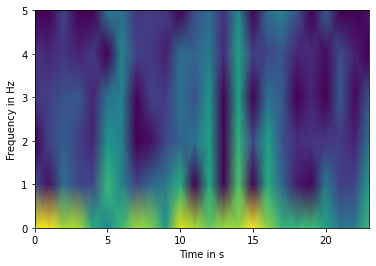

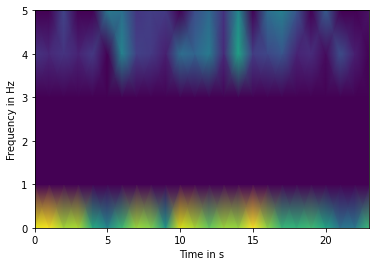

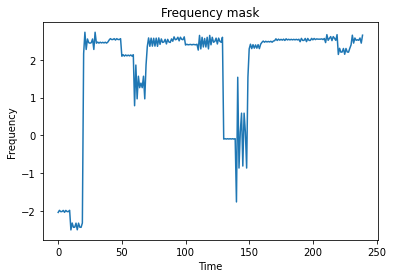

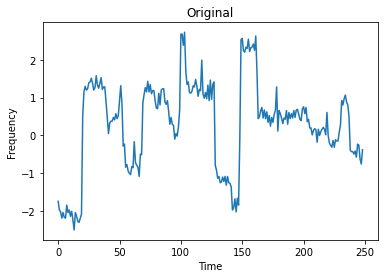

freq


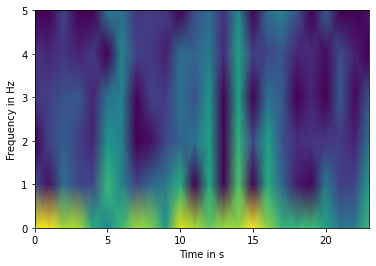

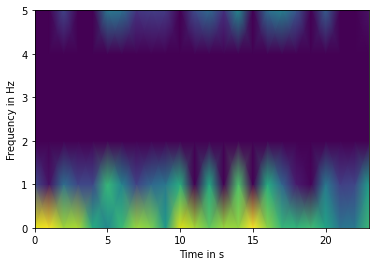

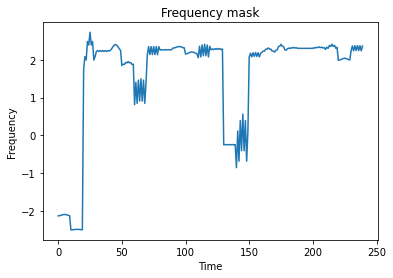

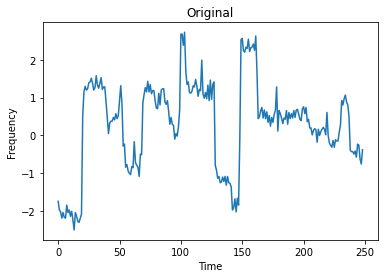

time


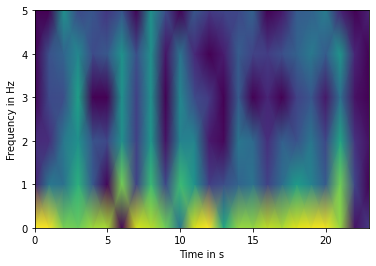

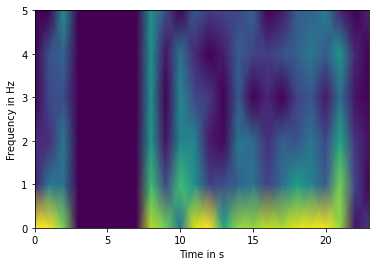

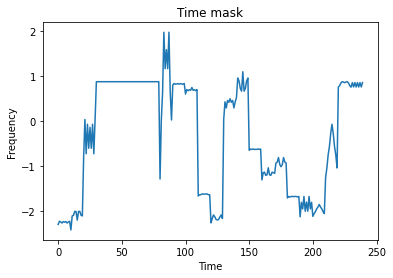

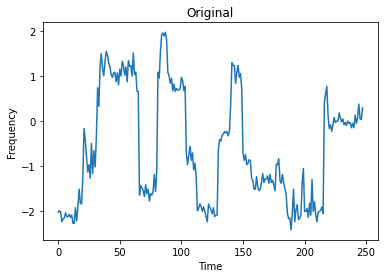

freq


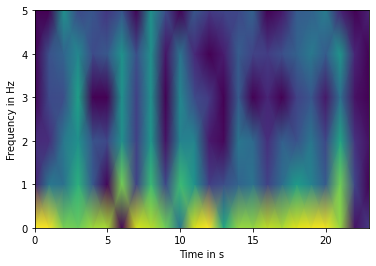

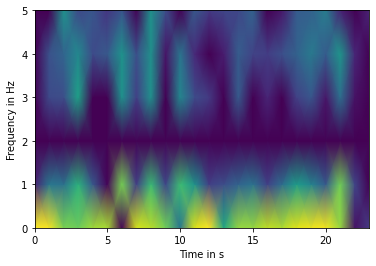

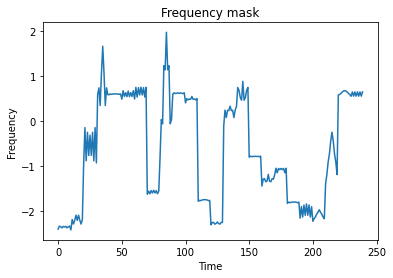

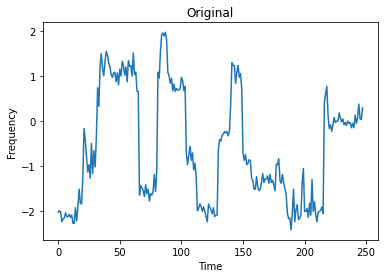

time


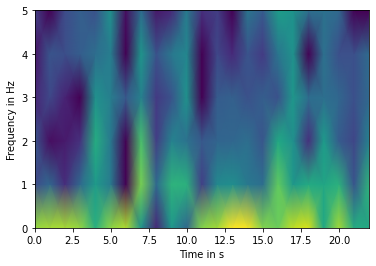

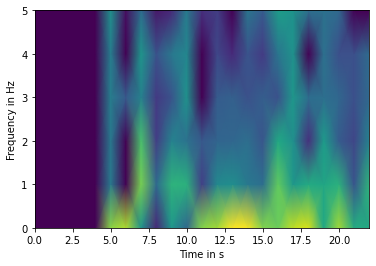

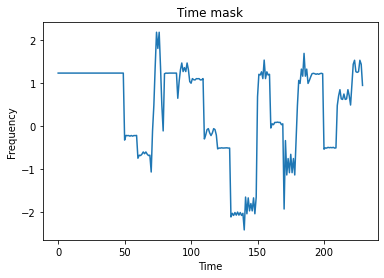

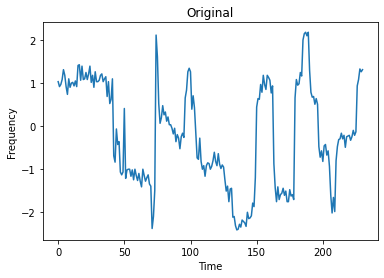

time


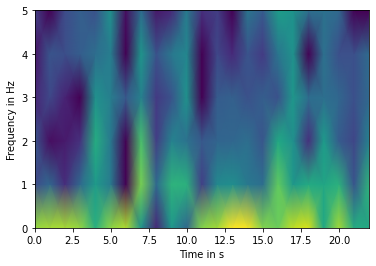

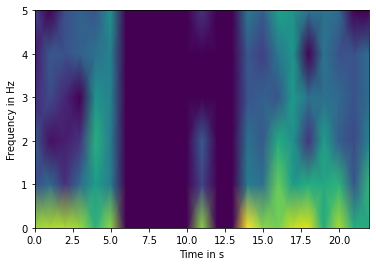

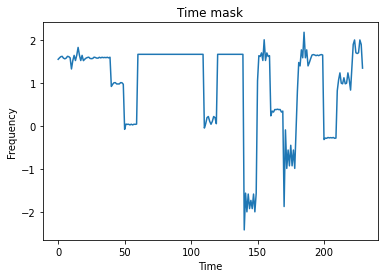

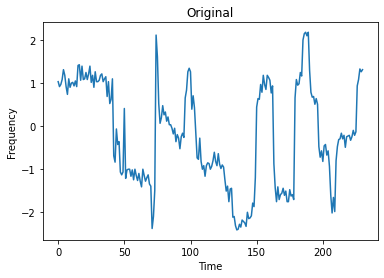

time


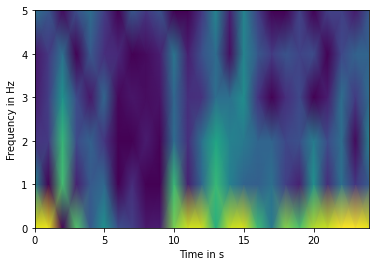

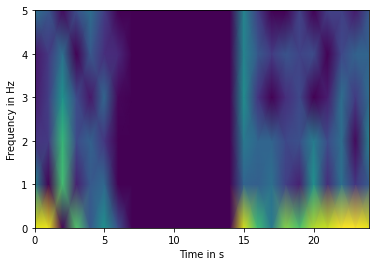

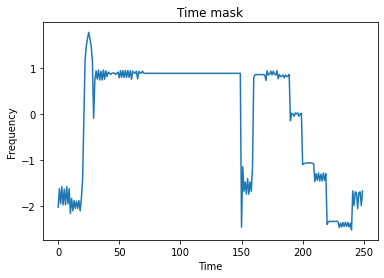

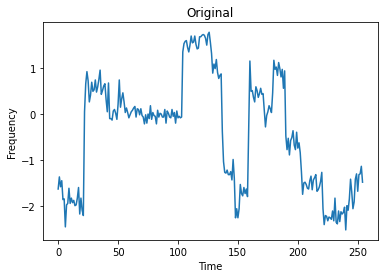

time


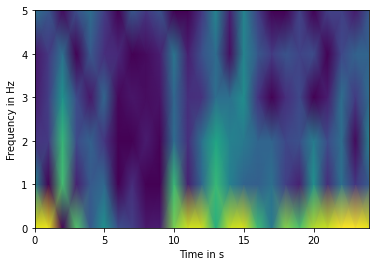

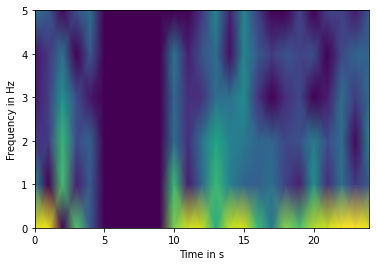

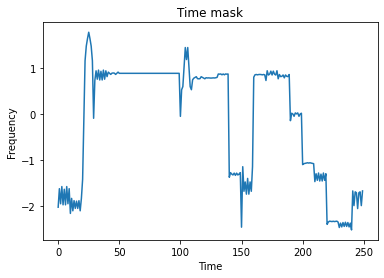

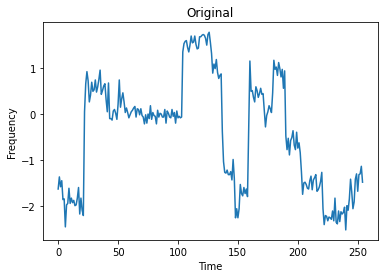

freq


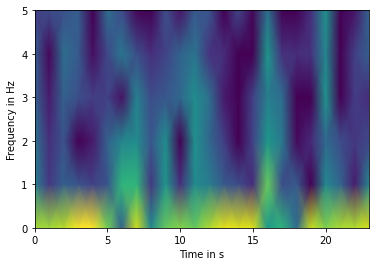

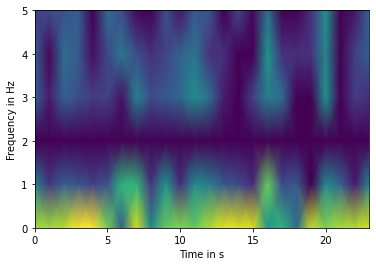

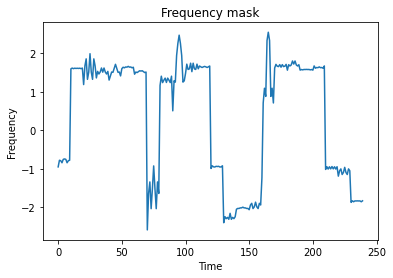

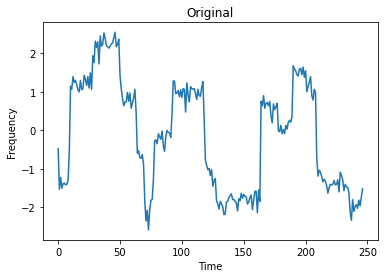

freq


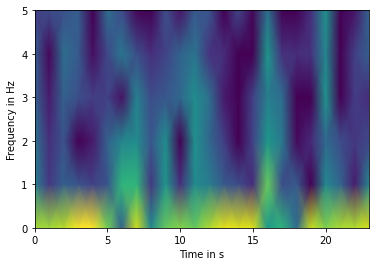

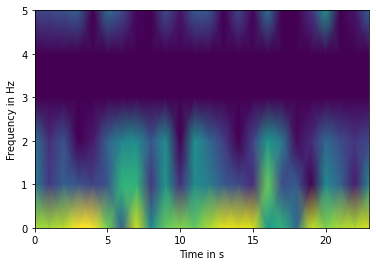

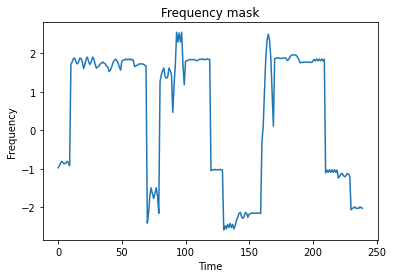

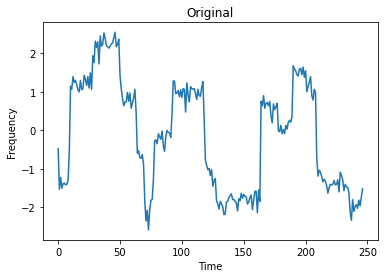

In [4]:
base_path = "/media/victor/USB/MSc_basecall/Data/3XR6/datasets/"

sig_path = base_path + "dataset_resquiggle_256/singal_output_train/ffd6ffd2-a3d9-4ceb-a611-d92a517be9cb.npy"
aug_sig = base_path + "aug_dataset_resquiggle_256/signal_output_aug/rrfvw83c.npy/"

augment(sig_path)





In [7]:
import numpy as np
base_path = "/media/victor/USB/MSc_basecall/Data/3XR6/datasets/"
ss = np.load(base_path + "aug_dataset_resquiggle_256/signal_output_aug/rrfvw83c.npy")
ss[0]

array([  0.75384322,   1.01455161,   0.9941416 ,   0.87221422,
         0.85728053,   1.08366844,   0.85728053,   0.87221422,
         0.9941416 ,   1.01455161,   0.8592063 ,   1.02294146,
         0.8741782 ,   1.02083097,   0.8686298 ,   1.01825142,
         0.8686298 ,   1.02083097,   0.8741782 ,   1.02294146,
         0.84297611,   0.97230727,   1.00845774,   0.87552417,
         0.90717995,   1.03051178,   0.90717995,   0.87552417,
         1.00845774,   0.97230727,   0.896066  ,   0.98310309,
         0.95578099,   1.00288874,   0.93467727,   0.94530644,
         0.93467727,   1.00288874,   0.95578099,   0.98310309,
         0.45840938,   0.96335192,   0.91594278,   1.24167431,
         0.63390453,   0.79015329,   0.63390453,   1.24167431,
         0.91594278,   0.96335192,   0.85938476,   0.8750852 ,
         0.87027549,   0.86877888,   0.86494607,   0.87671517,
         0.86494607,   0.86877888,   0.87027549,   0.8750852 ,
         0.63490752,   0.93172064,   0.89349618,   1.07

In [11]:
a = 1./0.
if a == np.NaN:
    print('nan')

ZeroDivisionError: float division by zero